# Loading libraries

In [1]:
from neuron import h, gui
from neuron.units import ms, mV
h.load_file('stdrun.hoc')

1.0

# Generic Cell class

In [2]:
# Let's make each Cell record its spike times, some membrane potential timeseries, and keep track of NetCons.

class Cell:
    def __init__(self, gid, x, y, z, theta):
        self._gid = gid
        self._setup_morphology()
        self.all = self.soma.wholetree()
        self._setup_biophysics()
        self.x = self.y = self.z = 0
        h.define_shape()
        self._rotate_z(theta)
        self._set_position(x, y, z)
        
        # everything below here in this method is NEW
        self._spike_detector = h.NetCon(self.soma(0.5)._ref_v, None, sec=self.soma)
        self.spike_times = h.Vector()
        self._spike_detector.record(self.spike_times)
        
        self._ncs = []
        
        self.soma_v = h.Vector().record(self.soma(0.5)._ref_v)

        
    def __repr__(self):
        return '{}[{}]'.format(self.name, self._gid)
    
    def _set_position(self, x, y, z):
        for sec in self.all:
            for i in range(sec.n3d()):
                sec.pt3dchange(i,
                               x - self.x + sec.x3d(i),
                               y - self.y + sec.y3d(i),
                               z - self.z + sec.z3d(i),
                              sec.diam3d(i))
        self.x, self.y, self.z = x, y, z
        
    def _rotate_z(self, theta):
        """Rotate the cell about the Z axis."""
        for sec in self.all:
            for i in range(sec.n3d()):
                x = sec.x3d(i)
                y = sec.y3d(i)
                c = h.cos(theta)
                s = h.sin(theta)
                xprime = x * c - y * s
                yprime = x * s + y * c
                sec.pt3dchange(i, xprime, yprime, sec.z3d(i), sec.diam3d(i))

In [3]:
# Since the BallAndStick has a simple geometry, 
# we could modify it to assume that all inputs go into a single location; 
# we will call it the .syn.

class BallAndStick(Cell):
    name = 'BallAndStick'
    
    def _setup_morphology(self):
        self.soma = h.Section(name='soma', cell=self)
        self.dend = h.Section(name='dend', cell=self)
        self.dend.connect(self.soma)
        self.soma.L = self.soma.diam = 12.6157
        self.dend.L = 200
        self.dend.diam = 1

    def _setup_biophysics(self):
        for sec in self.all:
            sec.Ra = 100    # Axial resistance in Ohm * cm
            sec.cm = 1      # Membrane capacitance in micro Farads / cm^2
            
        self.soma.insert('hh')   
        
        for seg in self.soma:
            seg.hh.gnabar = 0.12  # Sodium conductance in S/cm2
            seg.hh.gkbar = 0.036  # Potassium conductance in S/cm2
            seg.hh.gl = 0.0003    # Leak conductance in S/cm2
            seg.hh.el = -54.3     # Reversal potential in mV
            
        # Insert passive current in the dendrite
        self.dend.insert('pas')                 
        for seg in self.dend:
            seg.pas.g = 0.001  # Passive conductance in S/cm2
            seg.pas.e = -65    # Leak reversal potential mV

        # NEW: the synapse
        self.syn = h.ExpSyn(self.dend(0.5))
        self.syn.tau = 2 * ms

# Make a Ring class

In [4]:
class Ring:
    """A network of *N* ball-and-stick cells where cell n makes an
    excitatory synapse onto cell n + 1 and the last, Nth cell in the
    network projects to the first cell.
    """
    def __init__(self, N=5, stim_w=0.04, stim_t=9, stim_delay=1, syn_w=0.01, syn_delay=5, r=50):
        """
        :param N: Number of cells.
        :param stim_w: Weight of the stimulus
        :param stim_t: time of the stimulus (in ms)
        :param stim_delay: delay of the stimulus (in ms)
        :param syn_w: Synaptic weight
        :param syn_delay: Delay of the synapse
        :param r: radius of the network
        """ 
        self._syn_w = syn_w
        self._syn_delay = syn_delay
        self._create_cells(N, r)
        self._connect_cells()
        # add stimulus
        self._netstim = h.NetStim()
        self._netstim.number = 1
        self._netstim.start = stim_t
        self._nc = h.NetCon(self._netstim, self.cells[0].syn)
        self._nc.delay = stim_delay
        self._nc.weight[0] = stim_w
    
    def _create_cells(self, N, r):
        self.cells = []
        for i in range(N):
            theta = i * 2 * h.PI / N
            self.cells.append(BallAndStick(i, h.cos(theta) * r, h.sin(theta) * r, 0, theta))
    
    def _connect_cells(self):
        for source, target in zip(self.cells, self.cells[1:] + [self.cells[0]]):
            nc = h.NetCon(source.soma(0.5)._ref_v, target.syn, sec=source.soma)
            nc.weight[0] = self._syn_w
            nc.delay = self._syn_delay
            source._ncs.append(nc)    

# Test the network

In [5]:
# ring object with 5 cells
ring = Ring(N=5)

In [6]:
shape_window = h.PlotShape(True)
shape_window.show(0)

1.0

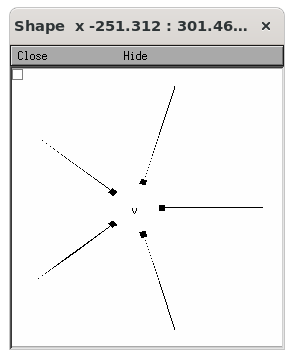

In [7]:
from IPython.display import Image
Image("Screenshot from 2023-07-12 16-35-39.png")

In [8]:
t = h.Vector().record(h._ref_t)
h.finitialize(-65 * mV)
h.continuerun(100)

0.0

In [9]:
%matplotlib inline

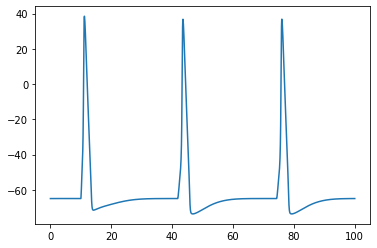

In [10]:
import matplotlib.pyplot as plt
plt.plot(t, ring.cells[0].soma_v)
plt.show()

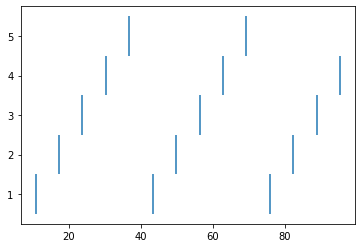

In [11]:
plt.figure()

for i, cell in enumerate(ring.cells):
    plt.vlines(list(cell.spike_times), i + 0.5, i + 1.5)

plt.show()

# Explore effects of parameters

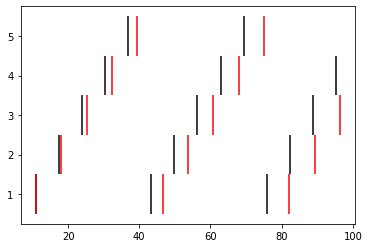

In [12]:
# compare two simulations: 
# one with the same parameters as above, which we'll plot in black 
# and one with half the synaptic weight, which we'll plot in red

plt.figure()

for syn_w, color in [(0.01, 'black'), (0.005, 'red')]:

    ring = Ring(N=5, syn_w=syn_w)
    h.finitialize(-65 * mV)
    h.continuerun(100 * ms)
    
    for i, cell in enumerate(ring.cells):
        plt.vlines(list(cell.spike_times), i + 0.5, i + 1.5, color=color)

plt.show()